# Descriptive Anaylsis of the Sorption Dataset

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from preprocessing.utils import unify_sorbent, unify_doi

csv_path = Path(os.getcwd()) / "data" / "raw_hyplast_w_smiles.csv"
plot_path = Path(os.getcwd()) / "plots" / "descriptive_analysis"
os.makedirs(plot_path, exist_ok=True)

raw_data = pd.read_csv(csv_path)
raw_data = raw_data[raw_data['r2'] >= 0.85]
raw_data = raw_data[~raw_data['SSA (m^2/g)'].isna()]
raw_data['cleaned_sorbent'] = raw_data['sorbent_name'].apply(unify_sorbent)
raw_data = raw_data[~raw_data['cleaned_sorbent'].str.startswith('modified')]

print(f"Data consists of {raw_data.shape[0]} rows of the following entities:")
print(f" From {raw_data["doi"].apply(lambda doi: unify_doi(doi, short=True)).unique().shape[0]} publications")
print(raw_data.columns)

# NA imputations
raw_data.loc[raw_data["T"] == "room temperature", "T"] = '25'
raw_data = raw_data.astype({'T': float})

raw_data.loc[raw_data['ph'].isna() & (raw_data['salinity'] > 30), 'ph'] = 8
raw_data.loc[raw_data['ph'].isna(), 'ph'] = 7

Data consists of 249 rows of the following entities:
 From 20 publications
Index(['ph', 'T', 'SLR (kg/L)', 'salinity', 'sorbat_name', 'sorbent_name',
       'SSA (m^2/g)', 'low conc_range (µg/L)', 'high conc_range (µg/L)', 'kf',
       'n', 'r2', 'scaled_n', 'scaled_kf', 'scaling', 'doi', 'smiles',
       'cleaned_sorbent'],
      dtype='str')


In [2]:
tbl_lines = [
    r"\begin{table}[htp]",
    r"  \begin{center}",
    r"    \begin{tabular}{c|c|c|c||c|c||c}",
    r"      & \multicolumn{3}{c||}{Matrix} & \multicolumn{2}{c}{Sorbat} & Sorbent\\",
    r"      \hline",
    r"      & pH & T [°C] & SLR $\left[\frac{kg}{L}\right]$ & "
    r"$C_{min}$ $\left[\frac{\mu g}{L}\right]$ & $C_{max}$ $\left[\frac{\mu g}{L}\right]$ &"
    r"SSA $\left[\frac{m^2}{g}\right]$ \\",
    r"      \hline \hline"
]
min_res, max_res = [], []
for col in ('ph', 'T', 'SLR (kg/L)', 'low conc_range (µg/L)', 'high conc_range (µg/L)', 'SSA (m^2/g)'):
    min_res.append(raw_data[col].min())
    max_res.append(raw_data[col].max())
tbl_lines.append(f"      min & {min_res[0]} & {min_res[1]} & {min_res[2]} & {min_res[3]} & {min_res[4]} & {min_res[5]}" + r" \\")
tbl_lines.append(f"      max & {max_res[0]} & {max_res[1]} & {max_res[2]} & {max_res[3]} & {max_res[4]} & {max_res[5]}" + r" \\")
tbl_lines.append(r"    \end{tabular}")
tbl_lines.append(r"  \end{center}")
tbl_lines.append(r"\end{table}")

print("\n".join(tbl_lines))

\begin{table}[htp]
  \begin{center}
    \begin{tabular}{c|c|c|c||c|c||c}
      & \multicolumn{3}{c||}{Matrix} & \multicolumn{2}{c}{Sorbat} & Sorbent\\
      \hline
      & pH & T [°C] & SLR $\left[\frac{kg}{L}\right]$ & $C_{min}$ $\left[\frac{\mu g}{L}\right]$ & $C_{max}$ $\left[\frac{\mu g}{L}\right]$ &SSA $\left[\frac{m^2}{g}\right]$ \\
      \hline \hline
      min & 6.0 & 10.0 & 1.5e-05 & 0.001 & 0.005 & 0.01 \\
      max & 8.2 & 35.0 & 0.025 & 5538.6 & 115303.0 & 78.94736842105263 \\
    \end{tabular}
  \end{center}
\end{table}


## Meta Data

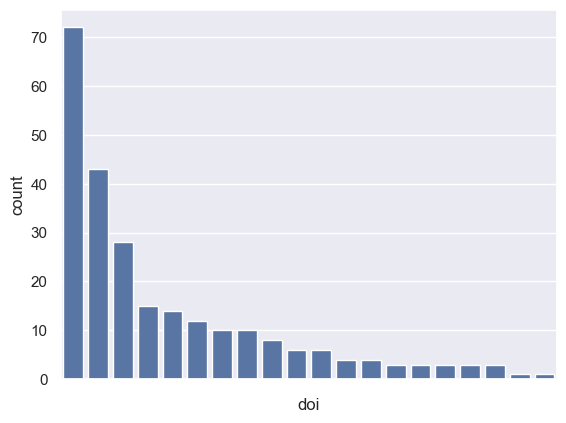

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


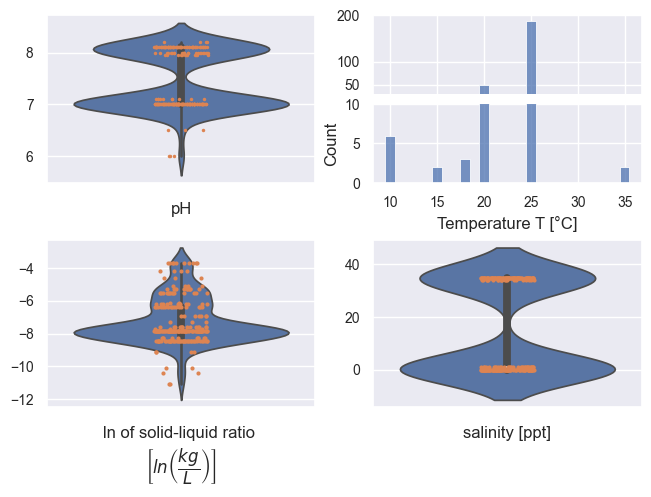

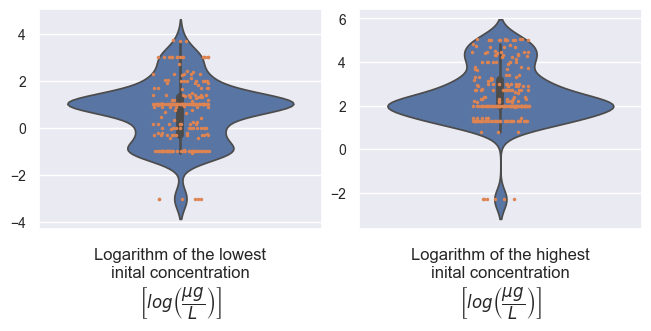

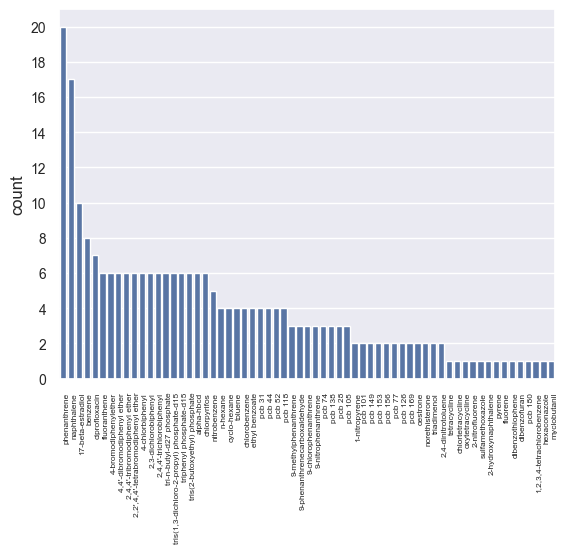

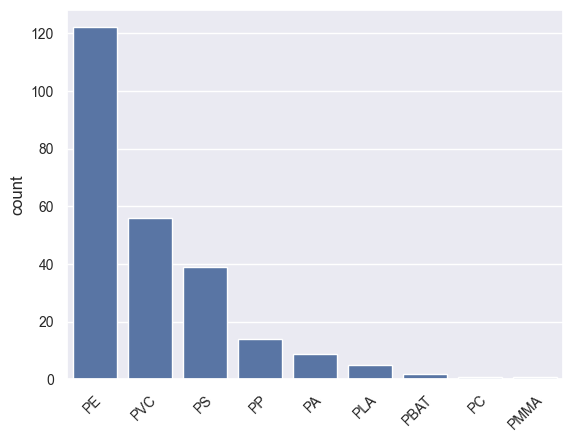

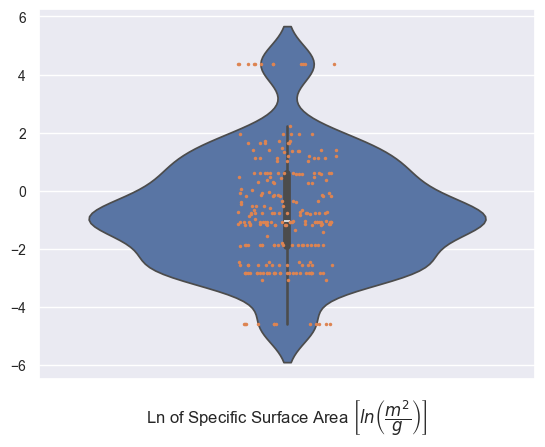

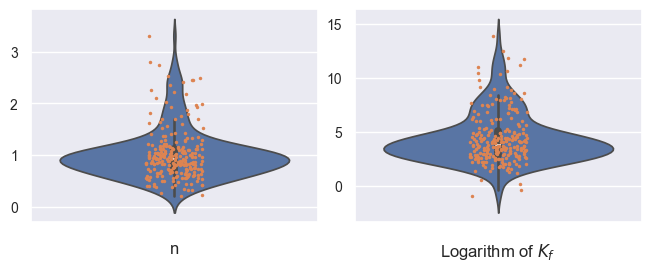

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from preprocessing.utils import unify_doi, unify_sorbent

# Apply the default theme
sns.set_theme()

# dois
dois = raw_data["doi"].apply(lambda doi: unify_doi(doi, short=True))
ax = sns.countplot(x=dois, order=dois.value_counts().index, orient='x')
ax.set_xticklabels([])
plt.savefig(plot_path / "doi_count.eps", dpi=1200, bbox_inches = "tight")
plt.show()


# Matrix properties
# broken axis in subplots adapted from https://stackoverflow.com/a/44731621
# copyright cc-by-sa ImportanceOfbeingErnest
plt.subplots(2,2, layout='constrained')
sns.violinplot(raw_data["ph"], ax=plt.subplot(221))
sns.stripplot(raw_data["ph"], ax=plt.subplot(221), s=2.5)
plt.subplot(221).set_ylabel("")
plt.subplot(221).set_xlabel("pH")
plt.subplot(221).tick_params(axis='y', labelsize='small')

divider = make_axes_locatable(plt.subplot(222))
ax2 = divider.new_vertical(size="100%", pad=0.1)
plt.gcf().add_axes(ax2)
sns.histplot(raw_data["T"], discrete=True, ax=ax2)
plt.subplot(222).set_xlabel("Temperature T [°C]")
plt.subplot(222).set_ylabel("")
plt.subplot(222).tick_params(axis='both', labelsize='small')
plt.subplot(222).set_ylim(0, 10)
plt.subplot(222).spines['top'].set_visible(False)
ax2.set_ylim(30, 200)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.tick_params(axis='both', labelsize='small', labelbottom=False)
ax2.set_yticks([50,100,200])
ax2.spines['bottom'].set_visible(False)
sns.histplot(raw_data["T"], discrete=True, ax=plt.subplot(222))


sns.violinplot(np.log(raw_data["SLR (kg/L)"]), ax=plt.subplot(223))
sns.stripplot(np.log(raw_data["SLR (kg/L)"]), ax=plt.subplot(223), s=3)
plt.subplot(223).set_ylabel("")
plt.subplot(223).set_xlabel("ln of solid-liquid ratio \n" + r"$\left[ln\left(\dfrac{kg}{L}\right)\right]$")
plt.subplot(223).tick_params(axis='y', labelsize='small')

raw_data.loc[raw_data['salinity'].isna(), 'salinity'] = 0.1
sns.violinplot(raw_data['salinity'], ax=plt.subplot(224))
sns.stripplot(raw_data['salinity'], ax=plt.subplot(224), s=3)
plt.subplot(224).set_xlabel("salinity [ppt]")
plt.subplot(224).set_ylabel("")
plt.subplot(224).tick_params(axis='y', labelsize='small')
plt.savefig(plot_path / "matrix.eps", dpi=1200, bbox_inches = "tight")
plt.show()

# Concentration range
plt.subplots(1, 2, layout='constrained', figsize=(6.4, 3.2))
sns.violinplot(np.log10(raw_data["low conc_range (µg/L)"]), ax=plt.subplot(121))
sns.stripplot(np.log10(raw_data["low conc_range (µg/L)"]), ax=plt.subplot(121), s=2.5)
plt.subplot(121).set_ylabel("")
plt.subplot(121).set_xlabel("Logarithm of the lowest\ninital concentration\n" + r"$\left[log\left(\dfrac{µg}{L}\right)\right]$")
plt.subplot(121).tick_params(axis='y', labelsize='small')

sns.violinplot(np.log10(raw_data["high conc_range (µg/L)"]), ax=plt.subplot(122))
sns.stripplot(np.log10(raw_data["high conc_range (µg/L)"]), ax=plt.subplot(122), s=2.5)
plt.subplot(122).set_ylabel("")
plt.subplot(122).set_xlabel("Logarithm of the highest\ninital concentration\n" + r"$\left[log\left(\dfrac{µg}{L}\right)\right]$")
plt.subplot(122).tick_params(axis='y', labelsize='small')
plt.savefig(plot_path / "crange.eps", dpi=1200, bbox_inches = "tight")
plt.show()


# Smiles
sorbat = raw_data["sorbat_name"].apply(str.lower)
sns.countplot(x=sorbat, order=sorbat.value_counts().index, orient='x')
ax = plt.gca()
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize='small')
ax.set_yticks(np.arange(0,22,2))
ax.set_xlabel("")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.savefig(plot_path / "sorbat_names.eps", dpi=1200, bbox_inches = "tight")
plt.show()

# Sorbents

sorbent = raw_data['sorbent_name'].apply(unify_sorbent)
sns.countplot(x=sorbent, order=sorbent.value_counts().index, orient='x')
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.gca().tick_params(axis='both', labelsize='small')
plt.gca().set_xlabel("")
plt.savefig(plot_path / "sorbent_names.eps", dpi=1200, bbox_inches = "tight")
plt.show()

# BET
sns.violinplot(np.log(raw_data["SSA (m^2/g)"]))
sns.stripplot(np.log(raw_data["SSA (m^2/g)"]), s=2.5)
plt.gca().tick_params(axis='both', labelsize='small')
plt.gca().set_ylabel("")
plt.gca().set_xlabel(r"Ln of Specific Surface Area $\left[ln\left(\dfrac{m^2}{g}\right)\right]$")
plt.savefig(plot_path / "bet.eps", dpi=1200)
plt.show()

# freundlich parameters
plt.subplots(1, 2, layout='constrained', figsize=(6.4, 2.6))
sns.violinplot(raw_data["scaled_n"], ax=plt.subplot(121))
sns.stripplot(raw_data["scaled_n"], ax=plt.subplot(121), s=2.5)
plt.subplot(121).set_ylabel("")
plt.subplot(121).set_xlabel("n")
plt.subplot(121).tick_params(axis='y', labelsize='small')

sns.violinplot(np.log10(raw_data["scaled_kf"]), ax=plt.subplot(122))
sns.stripplot(np.log10(raw_data["scaled_kf"]), ax=plt.subplot(122), s=2.5)
plt.subplot(122).set_ylabel("")
plt.subplot(122).set_xlabel(r"Logarithm of $K_f$")
plt.subplot(122).tick_params(axis='y', labelsize='small')
plt.savefig(plot_path / "freundlich.eps", dpi=1200, bbox_inches = "tight")
plt.show()
